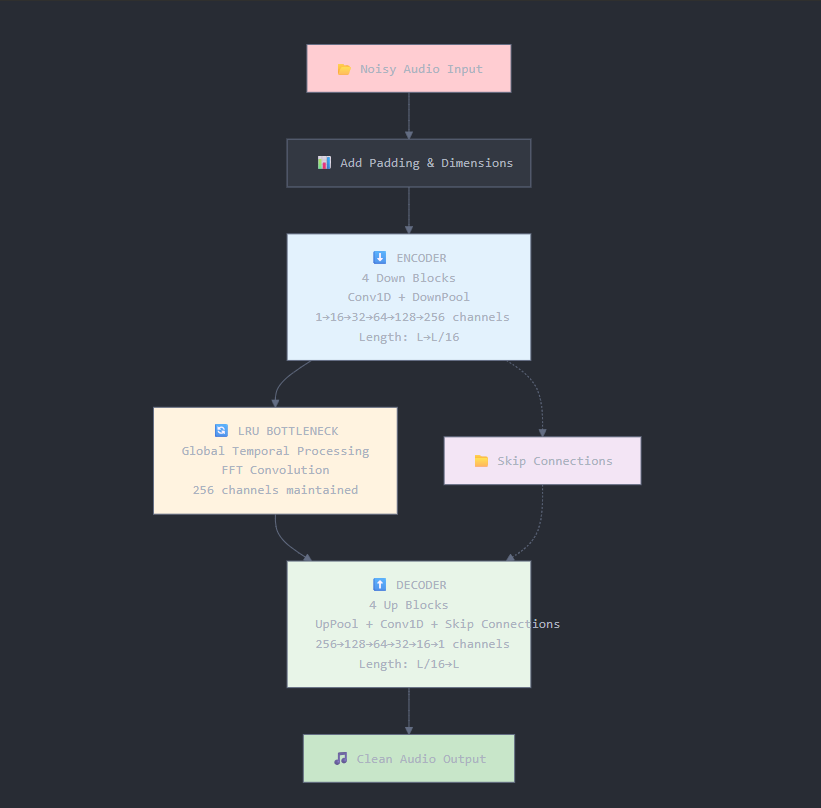




In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
import torchaudio
from torch.utils.data import DataLoader, Dataset
from pathlib import Path


class LRUBlock(nn.Module):
    def __init__(self, N, H):
        super().__init__()
        u1 = torch.rand(N)
        u2 = torch.rand(N)
        nu_log = torch.log(-0.5 * torch.log(u1 * (1**2 - 0**2) + 0**2))
        theta_log = torch.log(6.28 * u2)
        self.nu_log = nn.Parameter(nu_log)
        self.theta_log = nn.Parameter(theta_log)
        self.B_re = nn.Parameter(torch.randn(N, H) / (2 * H) ** 0.5)
        self.B_im = nn.Parameter(torch.randn(N, H) / (2 * H) ** 0.5)
        self.C_re = nn.Parameter(torch.randn(H, N) / N ** 0.5)
        self.C_im = nn.Parameter(torch.randn(H, N) / N ** 0.5)
        self.D = nn.Parameter(torch.randn(H))

    def forward(self, x):
        # Handle 1D audio data (B, C, L) instead of 2D images
        B, C, L = x.shape
        x_seq = x.transpose(1, 2)  # (B, L, C)
        
        Lamda = torch.exp(-torch.exp(self.nu_log)) * torch.exp(1j * torch.exp(self.theta_log))
        B_mat = self.B_re + 1j * self.B_im
        C_mat = self.C_re + 1j * self.C_im
        
        outputs = []
        for b in range(B):
            inp = x_seq[b]  # (L, C)
            Bu = torch.stack([B_mat @ u.to(torch.cfloat) for u in inp], dim=0)
            
            seq_len = Bu.shape[0]
            powers = torch.arange(seq_len, device=Bu.device).unsqueeze(1)
            Lamda_powers = Lamda.unsqueeze(0) ** powers
            
            fft_len = 2 * seq_len
            Bu_fft = torch.fft.fft(Bu, n=fft_len, dim=0)
            kernel_fft = torch.fft.fft(Lamda_powers, n=fft_len, dim=0)
            h_fft = Bu_fft * kernel_fft
            h = torch.fft.ifft(h_fft, dim=0)[:seq_len]
            
            y = torch.stack([(C_mat @ h[i]).real + self.D * inp[i] for i in range(seq_len)], dim=0)
            outputs.append(y)
        
        out = torch.stack(outputs, dim=0)
        out = out.transpose(1, 2)  # Back to (B, C, L)
        return out


class DownPool1D(nn.Module):
    def __init__(self, in_channels, downsample_factor=2):
        super().__init__()
        self.downsample_factor = downsample_factor
        self.conv = nn.Conv1d(in_channels, in_channels * 2, kernel_size=downsample_factor, stride=downsample_factor)
        
    def forward(self, x):
        return self.conv(x)


class UpPool1D(nn.Module):
    def __init__(self, in_channels, upsample_factor=2):
        super().__init__()
        self.upsample_factor = upsample_factor
        self.conv = nn.ConvTranspose1d(in_channels, in_channels // 2, kernel_size=upsample_factor, stride=upsample_factor)
        
    def forward(self, x):
        return self.conv(x)


class UNetLRUAudio(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128]):
        super().__init__()
        self.down_blocks = nn.ModuleList()
        self.down_pools = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.up_pools = nn.ModuleList()
        
        # Encoder
        current_channels = in_channels
        for feat in features:
            self.down_blocks.append(nn.Sequential(
                nn.Conv1d(current_channels, feat, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(feat, feat, kernel_size=3, padding=1),
                nn.ReLU(),
            ))
            self.down_pools.append(DownPool1D(feat))
            current_channels = feat * 2
        
        # Bottleneck with LRU
        self.lru = LRUBlock(N=current_channels, H=current_channels)
        
        # Decoder
        rev_feats = list(reversed(features))
        for feat in rev_feats:
            self.up_pools.append(UpPool1D(feat * 2))
            self.up_blocks.append(nn.Sequential(
                nn.Conv1d(feat * 2, feat, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(feat, feat, kernel_size=3, padding=1),
                nn.ReLU(),
            ))
        
        self.final = nn.Conv1d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skips = []
        
        # Encoder
        for down_block, down_pool in zip(self.down_blocks, self.down_pools):
            x = down_block(x)
            skips.append(x)
            x = down_pool(x)
        
        # Bottleneck
        x = self.lru(x)
        
        # Decoder
        skips = skips[::-1]
        for up_pool, up_block, skip in zip(self.up_pools, self.up_blocks, skips):
            x = up_pool(x)
            # Handle size mismatch
            if x.shape[-1] != skip.shape[-1]:
                x = F.interpolate(x, size=skip.shape[-1], mode='linear', align_corners=False)
            x = torch.cat((skip, x), dim=1)
            x = up_block(x)
        
        return self.final(x)
    
    def denoise_single(self, noisy):
        """Denoise a single audio sample"""
        # Handle different input shapes
        if noisy.ndim == 1:
            noisy = noisy.unsqueeze(0)  # Add batch dimension
        
        if noisy.ndim == 2:
            noisy = noisy.unsqueeze(1)  # Add channel dimension
        
        with torch.no_grad():
            denoised = self.forward(noisy)
        
        return denoised.squeeze(1)
    
    def denoise_multiple(self, noisy_samples):
        """Denoise multiple audio samples"""
        return [self.denoise_single(noisy) for noisy in noisy_samples]


class AudioDenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, sample_rate=16000, max_length=16000):
        self.noisy_dir = Path(noisy_dir)
        self.clean_dir = Path(clean_dir)
        self.sample_rate = sample_rate
        self.max_length = max_length
        
        self.noisy_files = sorted(list(self.noisy_dir.glob('*.wav')))
        self.clean_files = sorted(list(self.clean_dir.glob('*.wav')))
        
        assert len(self.noisy_files) == len(self.clean_files), "Number of noisy and clean files must match"
    
    def __len__(self):
        return len(self.noisy_files)
    
    def __getitem__(self, idx):
        # Load noisy audio
        noisy_audio, _ = librosa.load(self.noisy_files[idx], sr=self.sample_rate)
        clean_audio, _ = librosa.load(self.clean_files[idx], sr=self.sample_rate)
        
        # Ensure same length
        min_len = min(len(noisy_audio), len(clean_audio))
        noisy_audio = noisy_audio[:min_len]
        clean_audio = clean_audio[:min_len]
        
        # Truncate or pad to max_length
        if len(noisy_audio) > self.max_length:
            start = np.random.randint(0, len(noisy_audio) - self.max_length)
            noisy_audio = noisy_audio[start:start + self.max_length]
            clean_audio = clean_audio[start:start + self.max_length]
        else:
            pad_len = self.max_length - len(noisy_audio)
            noisy_audio = np.pad(noisy_audio, (0, pad_len), mode='constant')
            clean_audio = np.pad(clean_audio, (0, pad_len), mode='constant')
        
        return torch.tensor(noisy_audio, dtype=torch.float32), torch.tensor(clean_audio, dtype=torch.float32)


def train_audio_unet_lru(noisy_dir, clean_dir, epochs=50, batch_size=16, learning_rate=1e-3):
    """
    Train the Audio U-Net LRU model for denoising
    
    Args:
        noisy_dir: Directory containing noisy audio files
        clean_dir: Directory containing clean audio files
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
    """
    # Create dataset and dataloader
    dataset = AudioDenoisingDataset(noisy_dir, clean_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Initialize model
    model = UNetLRUAudio()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    print(f"Training on {device}")
    print(f"Dataset size: {len(dataset)}")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for i, (noisy, clean) in enumerate(dataloader):
            noisy = noisy.unsqueeze(1).to(device)  # Add channel dimension
            clean = clean.unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if i % 50 == 49:
                print(f"[Epoch {epoch+1}/{epochs}, Batch {i+1}] Loss: {running_loss/50:.6f}")
                running_loss = 0.0
        
        scheduler.step()
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f'audio_unet_lru_epoch_{epoch+1}.pt')
            print(f"Checkpoint saved at epoch {epoch+1}")
    
    return model


def create_synthetic_training_data(output_dir, num_samples=1000):
    """
    Create synthetic training data for demonstration
    """
    output_dir = Path(output_dir)
    noisy_dir = output_dir / "noisy"
    clean_dir = output_dir / "clean"
    
    noisy_dir.mkdir(parents=True, exist_ok=True)
    clean_dir.mkdir(parents=True, exist_ok=True)
    
    sample_rate = 16000
    duration = 1.0  # 1 second
    
    for i in range(num_samples):
        # Generate clean signal (sine wave + harmonics)
        t = np.linspace(0, duration, int(sample_rate * duration))
        freq = np.random.uniform(200, 800)  # Random frequency
        clean_signal = np.sin(2 * np.pi * freq * t) + 0.3 * np.sin(2 * np.pi * 2 * freq * t)
        
        # Add noise to create noisy signal
        noise_level = np.random.uniform(0.1, 0.5)
        noise = np.random.normal(0, noise_level, len(clean_signal))
        noisy_signal = clean_signal + noise
        
        # Save files
        torchaudio.save(str(clean_dir / f"clean_{i:04d}.wav"), 
                       torch.tensor(clean_signal, dtype=torch.float32).unsqueeze(0), 
                       sample_rate)
        torchaudio.save(str(noisy_dir / f"noisy_{i:04d}.wav"), 
                       torch.tensor(noisy_signal, dtype=torch.float32).unsqueeze(0), 
                       sample_rate)
    
    print(f"Created {num_samples} synthetic audio samples in {output_dir}")
    return str(noisy_dir), str(clean_dir)


if __name__ == '__main__':
    # Create synthetic training data
    noisy_dir, clean_dir = create_synthetic_training_data("./synthetic_audio_data", num_samples=500)
    
    # Train the model
    model = train_audio_unet_lru(noisy_dir, clean_dir, epochs=20, batch_size=8)
    
    # Save the final model
    torch.save(model.state_dict(), 'audio_unet_lru_final.pt')
    print("Training completed and model saved!")
    
    # Example usage for inference
    print("\nTesting inference...")
    model.eval()
    
    # Move model to CPU for inference if needed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Load a test sample
    try:
        test_noisy, _ = librosa.load(Path(noisy_dir) / "noisy_0000.wav", sr=16000)
        test_clean, _ = librosa.load(Path(clean_dir) / "clean_0000.wav", sr=16000)
        
        print(f"Test audio shape: {test_noisy.shape}")
        print(f"Test audio range: [{test_noisy.min():.3f}, {test_noisy.max():.3f}]")
        
        # Convert to tensor and move to device
        test_noisy_tensor = torch.tensor(test_noisy, dtype=torch.float32).to(device)
        
        # Denoise
        with torch.no_grad():
            denoised = model.denoise_single(test_noisy_tensor)
        
        # Move back to CPU for saving
        denoised_cpu = denoised.cpu()
        
        print(f"Denoised audio shape: {denoised_cpu.shape}")
        print(f"Denoised audio range: [{denoised_cpu.min():.3f}, {denoised_cpu.max():.3f}]")
        
        # Save denoised result
        if denoised_cpu.ndim == 1:
            denoised_cpu = denoised_cpu.unsqueeze(0)  # Add channel dimension for torchaudio
        
        torchaudio.save("test_denoised.wav", denoised_cpu, 16000)
        print("Test denoising completed. Check 'test_denoised.wav' for results.")
        
        # Also save original files for comparison
        torchaudio.save("test_noisy.wav", torch.tensor(test_noisy).unsqueeze(0), 16000)
        torchaudio.save("test_clean.wav", torch.tensor(test_clean).unsqueeze(0), 16000)
        print("Original noisy and clean files saved for comparison.")
        
    except Exception as e:
        print(f"Error during inference testing: {e}")
        print("Make sure the training data was created successfully and files exist.")

Created 500 synthetic audio samples in synthetic_audio_data
Training on cuda
Dataset size: 500
[Epoch 1/20, Batch 50] Loss: 0.259426
[Epoch 2/20, Batch 50] Loss: 0.018615
[Epoch 3/20, Batch 50] Loss: 0.012425
[Epoch 4/20, Batch 50] Loss: 0.008144
[Epoch 5/20, Batch 50] Loss: 0.005763
[Epoch 6/20, Batch 50] Loss: 0.004824
[Epoch 7/20, Batch 50] Loss: 0.004076
[Epoch 8/20, Batch 50] Loss: 0.003382
[Epoch 9/20, Batch 50] Loss: 0.003572
[Epoch 10/20, Batch 50] Loss: 0.003285
Checkpoint saved at epoch 10
[Epoch 11/20, Batch 50] Loss: 0.002250
[Epoch 12/20, Batch 50] Loss: 0.002020
[Epoch 13/20, Batch 50] Loss: 0.002113
[Epoch 14/20, Batch 50] Loss: 0.002138
[Epoch 15/20, Batch 50] Loss: 0.001870
[Epoch 16/20, Batch 50] Loss: 0.001698
[Epoch 17/20, Batch 50] Loss: 0.001877
[Epoch 18/20, Batch 50] Loss: 0.002058
[Epoch 19/20, Batch 50] Loss: 0.001917
[Epoch 20/20, Batch 50] Loss: 0.001741
Checkpoint saved at epoch 20
Training completed and model saved!

Testing inference...
Test audio shape: 